In [683]:
# Вначале - установим/импортируем необходимые библиотеки и добавим функции, которыми будем пользоваться
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [684]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [685]:
import warnings
warnings.simplefilter('ignore')

In [686]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [687]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [688]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [689]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [690]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [691]:
# Загрузим тренировочный и тестовый датасеты
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [692]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

# Посмотрим на тренировочный датасет подробнее

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [693]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [694]:
print (df_train.shape)
print (df_test.shape)

(7500, 17)
(2500, 16)


In [695]:
# Далее начнем проверять целостность
# Сначала загрузим информацию
df_train.info()
# В информации видно что есть три столбца (Ecology_2, Ecology_3, Shops_2) с номинативными переменными. Обработаем их попозже

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [696]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [697]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [698]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [699]:
# В датасете 4 столбца с категориальными переменными. При том столбец Years in current job - крайне просится быть переведенным
# в числовой тип. Кроме того в некоторых столбцах есть пропущенные значения. Выбросы - да вроде бы их и не прослеживается явно, 
# Поэтому ограничим часть столбцов (Maximum Open Credit, Current Loan Amount, Credit Score) по которым видны выбросы.
print (df_train['Years in current job'].value_counts())
print (df_test['Years in current job'].value_counts())

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64


In [700]:
# Самый, на мой взгляд, простой способ "оцифровать" столбец Years in current job (отсутствующие значения заменим медианными) :
df_train.loc[df_train['Years in current job'] == '10+ years', 'Years in current job'] = 10
df_train.loc[df_train['Years in current job'] == '< 1 year', 'Years in current job'] = 0
df_train.loc[df_train['Years in current job'] == '1 year', 'Years in current job'] = 1
df_train.loc[df_train['Years in current job'] == '2 years', 'Years in current job'] = 2
df_train.loc[df_train['Years in current job'] == '3 years', 'Years in current job'] = 3
df_train.loc[df_train['Years in current job'] == '4 years', 'Years in current job'] = 4
df_train.loc[df_train['Years in current job'] == '5 years', 'Years in current job'] = 5
df_train.loc[df_train['Years in current job'] == '6 years', 'Years in current job'] = 6
df_train.loc[df_train['Years in current job'] == '7 years', 'Years in current job'] = 7
df_train.loc[df_train['Years in current job'] == '8 years', 'Years in current job'] = 8
df_train.loc[df_train['Years in current job'] == '9 years', 'Years in current job'] = 9
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = df_train['Years in current job'].median()
df_train['Years in current job'] = df_train['Years in current job'].astype(int)
df_test.loc[df_test['Years in current job'] == '10+ years', 'Years in current job'] = 10
df_test.loc[df_test['Years in current job'] == '< 1 year', 'Years in current job'] = 0
df_test.loc[df_test['Years in current job'] == '1 year', 'Years in current job'] = 1
df_test.loc[df_test['Years in current job'] == '2 years', 'Years in current job'] = 2
df_test.loc[df_test['Years in current job'] == '3 years', 'Years in current job'] = 3
df_test.loc[df_test['Years in current job'] == '4 years', 'Years in current job'] = 4
df_test.loc[df_test['Years in current job'] == '5 years', 'Years in current job'] = 5
df_test.loc[df_test['Years in current job'] == '6 years', 'Years in current job'] = 6
df_test.loc[df_test['Years in current job'] == '7 years', 'Years in current job'] = 7
df_test.loc[df_test['Years in current job'] == '8 years', 'Years in current job'] = 8
df_test.loc[df_test['Years in current job'] == '9 years', 'Years in current job'] = 9
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].median()
df_test['Years in current job'] = df_test['Years in current job'].astype(int)

In [701]:
print (df_train['Years in current job'].value_counts())
print (df_test['Years in current job'].value_counts())

10    2332
6      797
2      705
3      620
0      563
5      516
1      504
4      469
7      396
8      339
9      259
Name: Years in current job, dtype: int64
10    810
3     228
6     223
2     212
0     207
5     169
1     153
4     152
7     140
8     107
9      99
Name: Years in current job, dtype: int64


In [702]:
# Попробуем оцифровать и другие столбцы с категориальными переменными 
#(почему нет? потом сравним с неоцифрованным (категориальным) вариантом): по итогам сравнения "оцифрованный" вариант оказался точнее.
print (df_train['Home Ownership'].value_counts())
print (df_test['Home Ownership'].value_counts())

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64


In [703]:
df_train.loc[df_train['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 1
df_train.loc[df_train['Home Ownership'] == 'Rent', 'Home Ownership'] = 2
df_train.loc[df_train['Home Ownership'] == 'Own Home', 'Home Ownership'] = 3
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 4
df_train['Home Ownership'] = df_train['Home Ownership'].astype(int)
df_test.loc[df_test['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 1
df_test.loc[df_test['Home Ownership'] == 'Rent', 'Home Ownership'] = 2
df_test.loc[df_test['Home Ownership'] == 'Own Home', 'Home Ownership'] = 3
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 4
df_test['Home Ownership'] = df_test['Home Ownership'].astype(int)

In [704]:
print (df_train['Home Ownership'].value_counts())
print (df_test['Home Ownership'].value_counts())

1    3637
2    3204
3     647
4      12
Name: Home Ownership, dtype: int64
1    1225
2    1020
3     248
4       7
Name: Home Ownership, dtype: int64


In [705]:
print (df_train['Purpose'].value_counts())
print (df_test['Purpose'].value_counts())

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64


In [706]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'] = 1
df_train.loc[df_train['Purpose'] == 'other', 'Purpose'] = 2
df_train.loc[df_train['Purpose'] == 'home improvements', 'Purpose'] = 3
df_train.loc[df_train['Purpose'] == 'business loan', 'Purpose'] = 4
df_train.loc[df_train['Purpose'] == 'buy a car', 'Purpose'] = 5
df_train.loc[df_train['Purpose'] == 'medical bills', 'Purpose'] = 6
df_train.loc[df_train['Purpose'] == 'major purchase', 'Purpose'] = 7
df_train.loc[df_train['Purpose'] == 'take a trip', 'Purpose'] = 8
df_train.loc[df_train['Purpose'] == 'buy house', 'Purpose'] = 9
df_train.loc[df_train['Purpose'] == 'small business', 'Purpose'] = 10
df_train.loc[df_train['Purpose'] == 'wedding', 'Purpose'] = 11
df_train.loc[df_train['Purpose'] == 'moving', 'Purpose'] = 12
df_train.loc[df_train['Purpose'] == 'educational expenses', 'Purpose'] = 13
df_train.loc[df_train['Purpose'] == 'vacation', 'Purpose'] = 14
df_train.loc[df_train['Purpose'] == 'renewable energy', 'Purpose'] = 15
df_train['Purpose'] = df_train['Purpose'].astype(int)
df_test.loc[df_test['Purpose'] == 'debt consolidation', 'Purpose'] = 1
df_test.loc[df_test['Purpose'] == 'other', 'Purpose'] = 2
df_test.loc[df_test['Purpose'] == 'home improvements', 'Purpose'] = 3
df_test.loc[df_test['Purpose'] == 'business loan', 'Purpose'] = 4
df_test.loc[df_test['Purpose'] == 'buy a car', 'Purpose'] = 5
df_test.loc[df_test['Purpose'] == 'medical bills', 'Purpose'] = 6
df_test.loc[df_test['Purpose'] == 'major purchase', 'Purpose'] = 7
df_test.loc[df_test['Purpose'] == 'take a trip', 'Purpose'] = 8
df_test.loc[df_test['Purpose'] == 'buy house', 'Purpose'] = 9
df_test.loc[df_test['Purpose'] == 'small business', 'Purpose'] = 10
df_test.loc[df_test['Purpose'] == 'wedding', 'Purpose'] = 11
df_test.loc[df_test['Purpose'] == 'moving', 'Purpose'] = 12
df_test.loc[df_test['Purpose'] == 'educational expenses', 'Purpose'] = 13
df_test.loc[df_test['Purpose'] == 'vacation', 'Purpose'] = 14
df_test.loc[df_test['Purpose'] == 'renewable energy', 'Purpose'] = 15
df_test['Purpose'] = df_test['Purpose'].astype(int)

In [707]:
print (df_train['Purpose'].value_counts())
print (df_test['Purpose'].value_counts())

1     5944
2      665
3      412
4      129
5       96
6       71
7       40
8       37
9       34
10      26
11      15
12      11
13      10
14       8
15       2
Name: Purpose, dtype: int64
1     1973
2      240
3      140
5       34
4       30
6       27
9       19
8       14
7        9
10       5
13       3
14       3
11       2
12       1
Name: Purpose, dtype: int64


In [708]:
print (df_train['Term'].value_counts())
print (df_test['Term'].value_counts())

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
Short Term    1861
Long Term      639
Name: Term, dtype: int64


In [709]:
df_train.loc[df_train['Term'] == 'Short Term', 'Term'] = 0
df_train.loc[df_train['Term'] == 'Long Term', 'Term'] = 1
df_train['Term'] = df_train['Term'].astype(int)
df_test.loc[df_test['Term'] == 'Short Term', 'Term'] = 0
df_test.loc[df_test['Term'] == 'Long Term', 'Term'] = 1
df_test['Term'] = df_test['Term'].astype(int)

In [710]:
print (df_train['Term'].value_counts())
print (df_test['Term'].value_counts())

0    5556
1    1944
Name: Term, dtype: int64
0    1861
1     639
Name: Term, dtype: int64


In [711]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null int32
Annual Income                   5943 non-null float64
Years in current job            7500 non-null int32
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null int32
Term                            7500 non-null int32
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7500 

In [712]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null int32
Annual Income                   1987 non-null float64
Years in current job            2500 non-null int32
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null int32
Term                            2500 non-null int32
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), int32(4)
memory 

In [713]:
# Проставим медианные значения в ячейках с отсутствующими значениями, кроме банкроств - там предлагаю проставить 0,
# т.к. пропущено 14 значений, и с бОльшей долей вероятности - у них банкроств не было.
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = df_train['Credit Score'].median()
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_test['Months since last delinquent'].median()
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_test['Credit Score'].median()

In [714]:
df_train.describe()
# Ограничим часть столбцов (Maximum Open Credit, Current Loan Amount, Credit Score) по которым видны выбросы.
# Для этого посмотрим распределение значений по этим столбцам

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.604533,1.325286e+06,5.886267,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.552400,0.259200,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733
std,0.649047,7.567551e+05,3.529503,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,1.551293,0.438225,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874
min,1.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,2.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,1.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,1.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,4.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,15.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [715]:
df_test.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.00000
mean,1.61480,1.328252e+06,5.951600,0.035200,11.184400,18.325920,7.105704e+05,0.162000,31.910000,0.106800,1.534400,0.255600,1.215572e+07,2.963966e+05,18271.340000,1131.19520
std,0.67246,8.211249e+05,3.573453,0.386291,4.852774,7.254659,1.511983e+06,0.559894,15.027103,0.356994,1.478949,0.436285,3.226097e+07,3.783020e+05,11543.881469,1564.62781
min,1.00000,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.00000
25%,1.00000,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,30.000000,0.000000,1.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.00000
50%,2.00000,1.178475e+06,6.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,1.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.00000
75%,2.00000,1.488726e+06,10.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,30.000000,0.000000,1.000000,1.000000,5.225825e+05,3.663485e+05,24146.000000,741.00000
max,4.00000,1.497561e+07,10.000000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,14.000000,1.000000,1.000000e+08,6.030087e+06,93555.000000,7480.00000


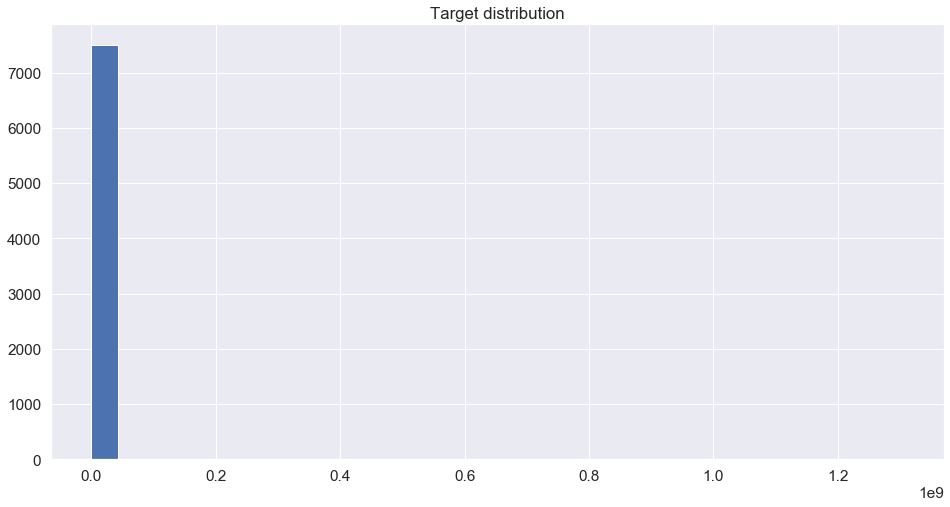

In [716]:
plt.figure(figsize = (16, 8))

df_train['Maximum Open Credit'].hist(bins=30)
plt.title('Target distribution')
plt.show()

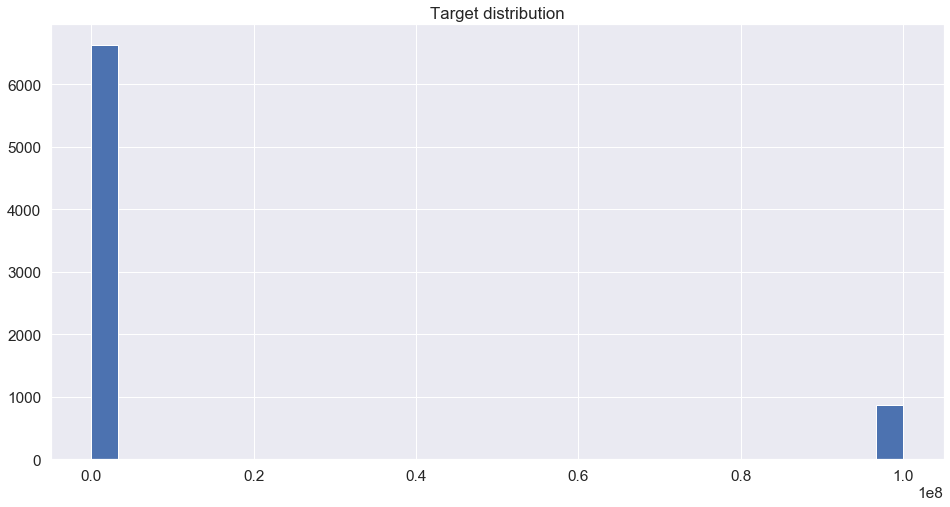

In [717]:
plt.figure(figsize = (16, 8))

df_train['Current Loan Amount'].hist(bins=30)
plt.title('Target distribution')
plt.show()

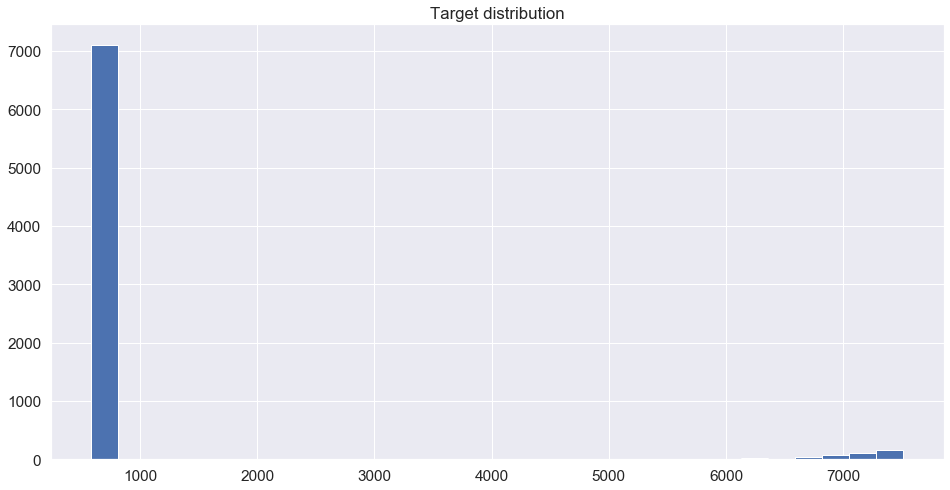

In [718]:
plt.figure(figsize = (16, 8))

df_train['Credit Score'].hist(bins=30)
plt.title('Target distribution')
plt.show()

In [719]:
# Очевидно, что во всех трех случаях мы имеем с выбросами вверхах (снизу выбросы мне сложно оценить,
# т.к. наверняка у людей могут быть околонулевые кредиты). Вот на что стоит внимание обратить, так это на кредитный рейтинг:
# у показателей кредитного рейтинга в выбросах - явная ошибка: прибавлен лишний ноль. Т.е. тут достаточно поделить на 10.
# А в других двух столбцах возмем просто медианные значения (можно через qunatile убрать, но тогда сильно сокращается датасет, а он и так небольшой).
df_train.loc[df_train['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = df_train['Maximum Open Credit'].median()

df_train.loc[df_train['Current Loan Amount'] > 10000000, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

df_train.loc[df_train['Credit Score'] > 2000, 'Credit Score'] = df_train['Credit Score'] / 10

df_train.describe()

# Значения Number of Open Accounts (43) и Years of Credit History (57.7) тоже немного подозрительные, но в теории реальные.

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.604533,1.325286e+06,5.886267,0.030133,11.130933,18.317467,6.433482e+05,0.170000,33.227467,0.116933,1.552400,0.259200,309088.029067,2.898332e+05,18314.454133,722.352533,0.281733
std,0.649047,7.567551e+05,3.529503,0.271604,4.908924,7.041946,6.743494e+05,0.498598,14.703950,0.346904,1.551293,0.438225,171393.740131,3.178714e+05,11926.764673,25.276816,0.449874
min,1.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,1.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.000000,0.000000,180169.000000,1.142565e+05,10067.500000,715.000000,0.000000
50%,2.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781535e+05,0.000000,32.000000,0.000000,1.000000,0.000000,309567.500000,2.093230e+05,16076.500000,731.000000,0.000000
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.905590e+05,0.000000,32.000000,0.000000,1.000000,1.000000,396929.500000,3.604062e+05,23818.000000,738.000000,1.000000
max,4.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,9.541136e+06,7.000000,118.000000,4.000000,15.000000,1.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000


In [720]:
# Повторим для тестовых данных
df_test.loc[df_test['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = df_test['Maximum Open Credit'].median()

df_test.loc[df_test['Current Loan Amount'] > 10000000, 'Current Loan Amount'] = df_test['Current Loan Amount'].median()

df_test.loc[df_test['Credit Score'] > 2000, 'Credit Score'] = df_test['Credit Score'] / 10

df_test.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000
mean,1.61480,1.328252e+06,5.951600,0.035200,11.184400,18.325920,6.570675e+05,0.162000,31.910000,0.106800,1.534400,0.255600,314016.832800,2.963966e+05,18271.340000,721.893200
std,0.67246,8.211249e+05,3.573453,0.386291,4.852774,7.254659,6.941045e+05,0.559894,15.027103,0.356994,1.478949,0.436285,171498.178859,3.783020e+05,11543.881469,25.144962
min,1.00000,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,15422.000000,0.000000e+00,93.000000,585.000000
25%,1.00000,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,30.000000,0.000000,1.000000,0.000000,187126.500000,1.101145e+05,10024.750000,714.000000
50%,2.00000,1.178475e+06,6.000000,0.000000,10.000000,17.000000,4.785440e+05,0.000000,30.000000,0.000000,1.000000,0.000000,322355.000000,2.073850e+05,16642.500000,731.000000
75%,2.00000,1.488726e+06,10.000000,0.000000,14.000000,22.100000,7.972635e+05,0.000000,30.000000,0.000000,1.000000,1.000000,398893.000000,3.663485e+05,24146.000000,738.000000
max,4.00000,1.497561e+07,10.000000,15.000000,48.000000,53.400000,8.693828e+06,15.000000,82.000000,5.000000,14.000000,1.000000,789096.000000,6.030087e+06,93555.000000,751.000000


In [721]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null int32
Annual Income                   7500 non-null float64
Years in current job            7500 non-null int32
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null int32
Term                            7500 non-null int32
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7500 

In [722]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null int32
Annual Income                   2500 non-null float64
Years in current job            2500 non-null int32
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Purpose                         2500 non-null int32
Term                            2500 non-null int32
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
dtypes: float64(12), int32(4)
memory 

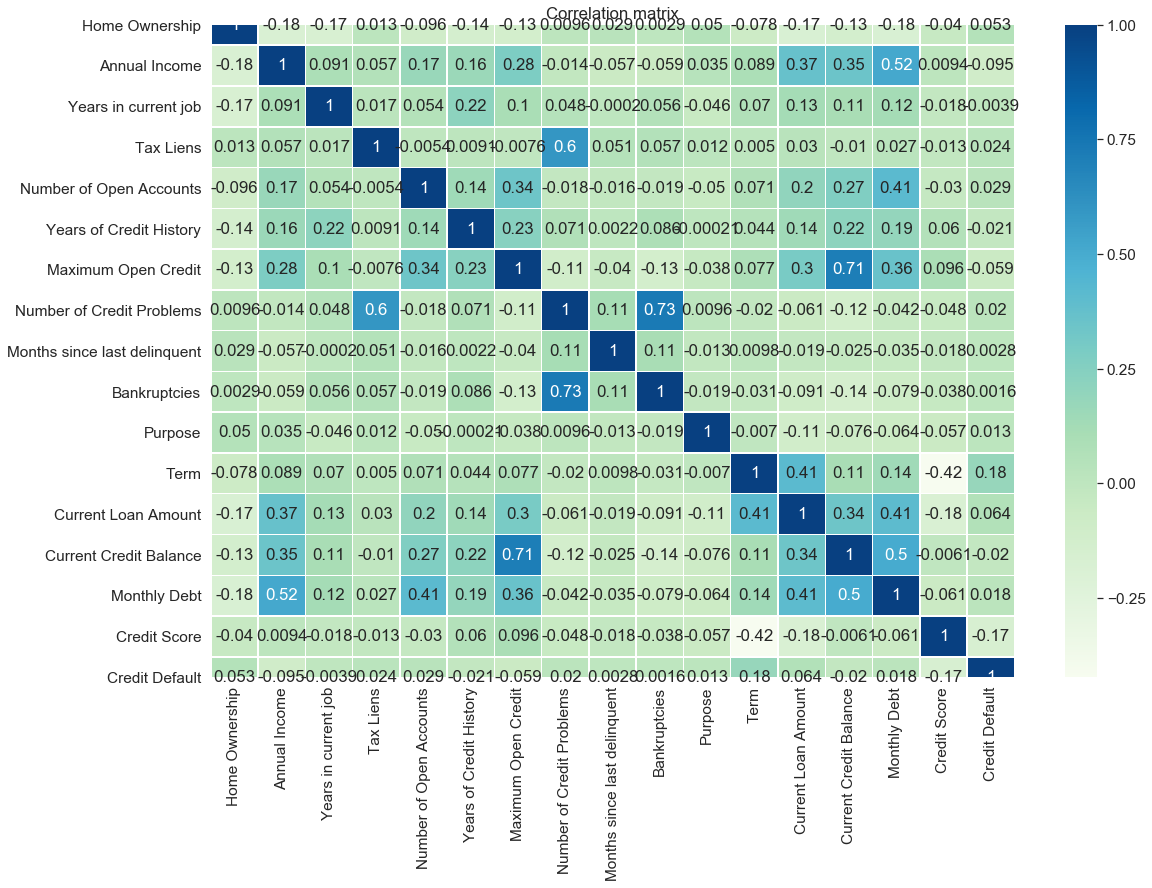

In [723]:
# Посмотрим как данные между собой коррелируют:
CorrKoef = df_train.corr()

plt.figure(figsize = (18,12))

sns.set(font_scale=1.4)
sns.heatmap(CorrKoef, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Никакого криминала нет, 0.6 и 0.7 есть в паре мест, но это не 0.9, пусть остаются.

In [724]:
# Введем дополнительные данные для повышения точности модели:
# 1. PTI - Годовой платеж / годовой доход - # не хватает данных, не стал вводить.
# 2. DTI - Годовой долг / годовой доход
# 3. PBP - (Долг + размер кредита) / годовой доход - сколько лет потребуется для выплаты кредита из дохода
# 4. Maximum open credit / current loan amount 
# 5. current loan amount  / Current credit balance
# 6. Annual income / current loan amount 

df_train['DTI'] = df_train['Monthly Debt'] * 12 / df_train['Annual Income']
df_train['PBP'] = df_train['Current Credit Balance'] / df_train['Annual Income']
df_train['Moc/cla'] = df_train['Maximum Open Credit'] / df_train['Current Loan Amount']
df_train['cla/crb'] = df_train['Current Loan Amount'] / df_train['Current Credit Balance']
df_train['ai/cla'] = df_train['Annual Income'] / df_train['Current Loan Amount']
df_train['CS/cla'] = df_train['Credit Score'] / df_train['Current Loan Amount']

df_test['DTI'] = df_test['Monthly Debt'] * 12 / df_test['Annual Income']
df_test['PBP'] = df_test['Current Credit Balance'] / df_test['Annual Income']
df_test['Moc/cla'] = round((df_test['Maximum Open Credit']),3) / round((df_test['Current Loan Amount']), 3)
df_test['cla/crb'] = df_test['Current Loan Amount'] / df_test['Current Credit Balance']
df_test['ai/cla'] = df_test['Annual Income'] / df_test['Current Loan Amount']
df_test['CS/cla'] = df_test['Credit Score'] / df_test['Current Loan Amount']

In [725]:
# В столбце cla/crb замечены значения 'inf' (бесконечность) из-за деления на ноль, как я понял. Заменим их на медианные
df_train[(df_train['cla/crb'] > 9999999)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla
91,2,601369.0,10,0.0,6.0,16.9,0.0,0.0,14.0,0.0,...,0.0,9021.0,738.0,0,0.180009,0.0,0.0,inf,3.624364,0.004448
196,2,815157.0,7,0.0,3.0,8.8,0.0,0.0,32.0,0.0,...,0.0,5855.0,738.0,0,0.086192,0.0,0.0,inf,3.738532,0.003385
294,1,2033931.0,7,0.0,6.0,21.1,0.0,0.0,32.0,0.0,...,0.0,30340.0,742.0,0,0.179003,0.0,0.0,inf,18.825373,0.006868
309,2,1245792.0,3,0.0,5.0,22.4,0.0,0.0,58.0,0.0,...,0.0,395.0,659.0,0,0.003805,0.0,0.0,inf,3.684729,0.001949
319,3,1168386.0,0,0.0,2.0,10.5,0.0,0.0,32.0,0.0,...,0.0,6432.0,731.0,0,0.066060,0.0,0.0,inf,15.239155,0.009534
544,1,1168386.0,2,0.0,15.0,22.5,0.0,0.0,32.0,0.0,...,0.0,22556.0,731.0,0,0.231663,0.0,0.0,inf,2.946051,0.001843
585,1,4772800.0,8,0.0,9.0,35.5,0.0,0.0,32.0,0.0,...,0.0,2227.0,747.0,0,0.005599,0.0,0.0,inf,15.417365,0.002413
780,1,867749.0,10,0.0,2.0,16.5,0.0,0.0,66.0,0.0,...,0.0,0.0,704.0,0,0.000000,0.0,0.0,inf,11.516244,0.009343
1163,1,4523064.0,3,0.0,6.0,14.2,0.0,0.0,38.0,0.0,...,0.0,19902.0,690.0,0,0.052801,0.0,0.0,inf,11.515281,0.001757
1338,2,1168386.0,2,0.0,8.0,17.6,0.0,0.0,43.0,0.0,...,0.0,12677.0,731.0,0,0.130200,0.0,0.0,inf,52.686959,0.032964


In [726]:
df_train.loc[df_train['cla/crb'] > 9999999, 'cla/crb'] = df_train['cla/crb'].median()
df_test.loc[df_test['cla/crb'] > 9999999, 'cla/crb'] = df_test['cla/crb'].median()

In [727]:
df_train[(df_train['cla/crb'] > 9999999)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla


In [728]:
df_test[(df_test['cla/crb'] > 9999999)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla


In [729]:
df_train.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,...,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.604533,1.325286e+06,5.886267,0.030133,11.130933,18.317467,6.433482e+05,0.170000,33.227467,0.116933,...,2.898332e+05,18314.454133,722.352533,0.281733,0.175129,0.230289,2.607294,12.933610,5.761802,0.003562
std,0.649047,7.567551e+05,3.529503,0.271604,4.908924,7.041946,6.743494e+05,0.498598,14.703950,0.346904,...,3.178714e+05,11926.764673,25.276816,0.449874,0.090706,0.202652,4.588036,446.956286,5.753091,0.003469
min,1.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.023027,0.700042,0.000769
25%,1.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,...,1.142565e+05,10067.500000,715.000000,0.000000,0.110996,0.101218,1.088224,0.825247,2.879396,0.001811
50%,2.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781535e+05,0.000000,32.000000,0.000000,...,2.093230e+05,16076.500000,731.000000,0.000000,0.167001,0.182173,1.725286,1.261531,4.246371,0.002413
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.905590e+05,0.000000,32.000000,0.000000,...,3.604062e+05,23818.000000,738.000000,1.000000,0.229942,0.302767,2.801657,2.092707,6.476987,0.004004
max,4.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,9.541136e+06,7.000000,118.000000,4.000000,...,6.506797e+06,136679.000000,751.000000,1.000000,0.987793,3.376037,259.841513,35372.526316,103.598513,0.066447


In [730]:
df_test.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla
count,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,...,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.61480,1.328252e+06,5.951600,0.035200,11.184400,18.325920,6.570675e+05,0.162000,31.910000,0.106800,...,314016.832800,2.963966e+05,18271.340000,721.893200,0.174854,0.229700,2.691030,7.505777,5.820869,0.003597
std,0.67246,8.211249e+05,3.573453,0.386291,4.852774,7.254659,6.941045e+05,0.559894,15.027103,0.356994,...,171498.178859,3.783020e+05,11543.881469,25.144962,0.088272,0.222684,4.346752,135.272591,6.746798,0.003769
min,1.00000,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,...,15422.000000,0.000000e+00,93.000000,585.000000,0.000988,0.000000,0.000000,0.017220,0.330472,0.000796
25%,1.00000,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,30.000000,0.000000,...,187126.500000,1.101145e+05,10024.750000,714.000000,0.111005,0.100834,1.062066,0.840190,2.864249,0.001792
50%,2.00000,1.178475e+06,6.000000,0.000000,10.000000,17.000000,4.785440e+05,0.000000,30.000000,0.000000,...,322355.000000,2.073850e+05,16642.500000,731.000000,0.172002,0.183083,1.695839,1.287635,4.071387,0.002314
75%,2.00000,1.488726e+06,10.000000,0.000000,14.000000,22.100000,7.972635e+05,0.000000,30.000000,0.000000,...,398893.000000,3.663485e+05,24146.000000,738.000000,0.230995,0.305411,2.832394,2.180882,6.276227,0.003902
max,4.00000,1.497561e+07,10.000000,15.000000,48.000000,53.400000,8.693828e+06,15.000000,82.000000,5.000000,...,789096.000000,6.030087e+06,93555.000000,751.000000,0.765796,5.116856,91.609214,6229.087719,149.685416,0.046557


In [731]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 23 columns):
Home Ownership                  7500 non-null int32
Annual Income                   7500 non-null float64
Years in current job            7500 non-null int32
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null int32
Term                            7500 non-null int32
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7500 

In [732]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
Home Ownership                  2500 non-null int32
Annual Income                   2500 non-null float64
Years in current job            2500 non-null int32
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Purpose                         2500 non-null int32
Term                            2500 non-null int32
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
DTI                             2500 

In [733]:
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,DTI,PBP,Moc/cla,cla/crb,ai/cla,CS/cla
0,2,1178475.0,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,162470.0,105906.0,6813.0,731.0,0.069374,0.089867,1.360054,1.534096,7.253493,0.004499
1,2,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,78298.0,46037.0,2318.0,699.0,0.119980,0.198574,0.714527,1.700762,2.960970,0.008927
2,1,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,...,200178.0,146490.0,18729.0,726.0,0.195002,0.127102,1.022090,1.366496,5.757576,0.003627
3,1,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,217382.0,213199.0,27559.0,739.0,0.271003,0.174708,2.099079,1.019620,5.613680,0.003400
4,1,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,...,777634.0,425391.0,42605.0,706.0,0.218398,0.181717,1.552494,1.828045,3.010352,0.000908
5,1,922583.0,5,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,...,94028.0,135508.0,11148.0,679.0,0.145002,0.146879,7.584698,0.693893,9.811790,0.007221
6,1,1233309.0,3,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,...,454388.0,292904.0,8181.0,685.0,0.079600,0.237494,0.828411,1.551321,2.714220,0.001508
7,2,1215867.0,3,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,...,407726.0,120099.0,7599.0,701.0,0.074998,0.098776,0.480440,3.394916,2.982069,0.001719
8,2,1178475.0,5,0.0,8.0,9.1,370524.0,0.0,30.0,0.0,...,131956.0,237747.0,10112.0,731.0,0.102967,0.201741,2.807936,0.555027,8.930818,0.005540
9,1,2140445.0,10,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,...,391336.0,294500.0,18372.0,745.0,0.102999,0.137588,2.217225,1.328815,5.469584,0.001904


In [734]:
# Произведем отбор признаков
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
                    'Credit Score']

NEW_FEATURE_NAMES = ['DTI', 'Moc/cla', 'ai/cla', 'PBP', 'cla/crb'] #'CS/cla', 

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES + CAT_FEATURE_NAMES

TARGET_NAME = 'Credit Default'

In [735]:
# Посмотрим на баланс целевой переменной. Баланс неплохой, но лучше произвести балансировку
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [736]:
# Применим стандартизацию
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

df = df_norm.copy()

# Тестовые данные тоже придется стандартизировать, т.к. при "сырых" данных - в предсказаниях получаются только нули, единиц нет совсем.
df_t_norm = df_test.copy()
df_t_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_t_norm[SELECTED_FEATURE_NAMES])

dft = df_t_norm.copy()

In [737]:
# Разобьем на train и valid + test впридачу
X = df[SELECTED_FEATURE_NAMES]

y = df[TARGET_NAME]

X_test = dft[SELECTED_FEATURE_NAMES]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=21)

In [738]:
# Произведем балансировку
df_for_balancing = pd.concat([X_train, y_train], axis=1)

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [739]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [740]:
# По результатам выбора оптимальной модели - лучшие результаты показала модель CatBoost. Её и приведу ниже.

final_model = catb.CatBoostClassifier(n_estimators=1800, max_depth=2,
                                      silent=True, random_state=42, learning_rate=0.01, l2_leaf_reg=10)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)
y_test = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      3771
           1       0.66      0.61      0.63      2958

    accuracy                           0.69      6729
   macro avg       0.69      0.68      0.68      6729
weighted avg       0.69      0.69      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1616
           1       0.45      0.56      0.50       634

    accuracy                           0.68      2250
   macro avg       0.63      0.64      0.63      2250
weighted avg       0.71      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1181  435
1                281  353


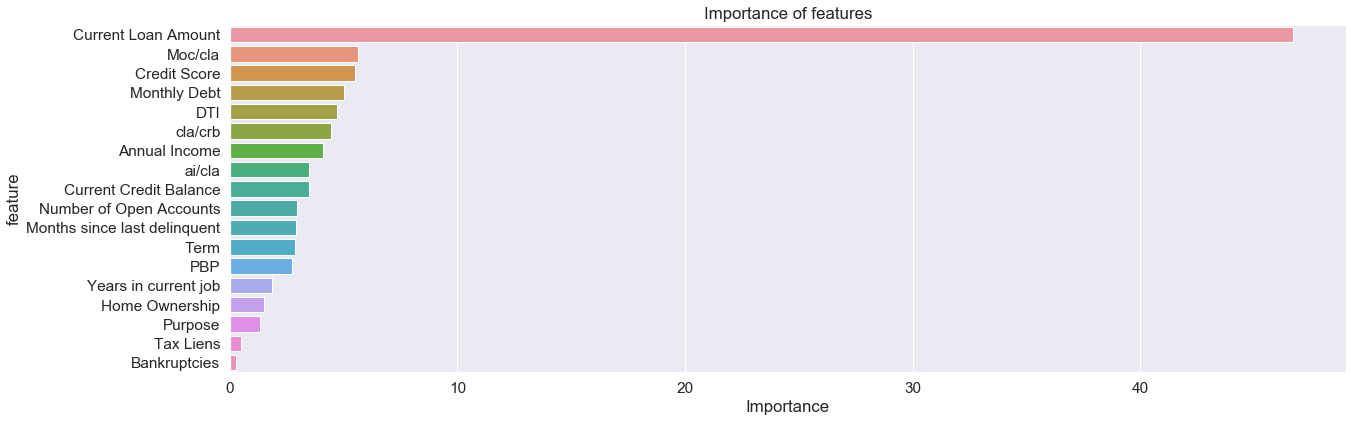

In [747]:
# Как видно - основной вклад вносит текущая сумма кредита. Я пробовал делать еще несколько дополнительных признаков
# в комбинации с кретидтным рейтингом и текущей суммой кредита - но все они только ухудшали показатели точности.
# Поэтому оставил именно этот набор параметров. Исключение любого из них, даже банкротства - ухудшает модель. 
# Добавление нового (из опробованных мной) - тоже ухудшает
final_model.fit(X_train, y_train)
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=25)

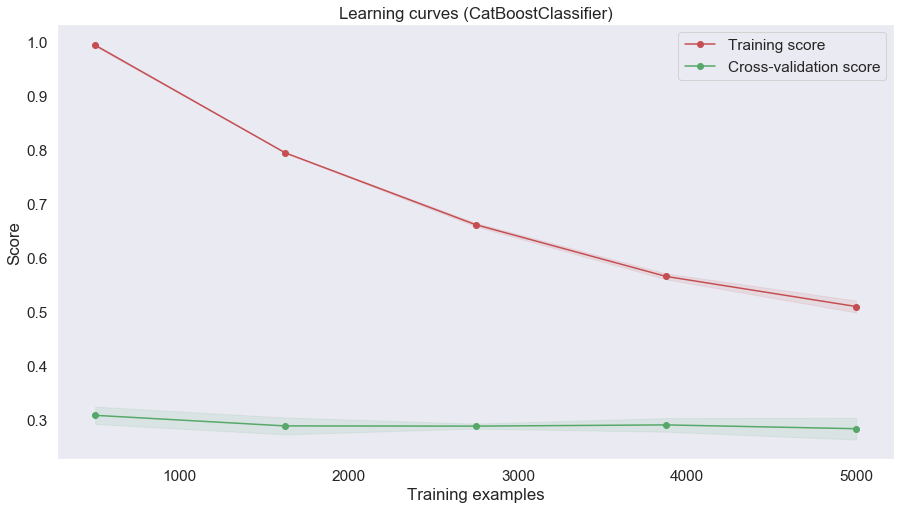

In [742]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=6,
                                      silent=True, random_state=21)
show_learning_curve_plot(final_model, X, y)

In [743]:
# Создадим датафрейм со столбцом индекса и предсказанными данными
index_test = np.linspace(1, 2500, 2500)

In [744]:
y_test_dict = {
    "Id": index_test,
    "Credit Default_Test": y_test
}

CD_test = pd.DataFrame(y_test_dict)

CD_test['Id'] = CD_test['Id'].astype(int)

CD_test

,Id,Credit Default_Test
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1
...,...,...
2495,2496,0
2496,2497,1
2497,2498,1
2498,2499,1


In [745]:
# Проверим есть ли "единички"
CD_test['Credit Default_Test'].value_counts()

0    1399
1    1101
Name: Credit Default_Test, dtype: int64

In [746]:
CD_test.to_csv('MALyakishev_predictions_cp2.csv', index=False, encoding='utf-8')